#This Notebook is to do the EDA of the dataset

In [ ]:
from google.colab import drive
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil


In [ ]:
drive.mount("/content/drive")
NEPAL_IMAGE_TO_DOWNLOAD = "/content/drive/MyDrive/NeuralNetwork/nepal_images_to_download.csv"
NEPAL_IMAGES = "/content/drive/MyDrive/NeuralNetwork/nepal_dataset"
ID_MAP_NAME = "/content/drive/MyDrive/NeuralNetwork/nepal_monuments.csv"
OUTPUT_PATH = '/content/drive/MyDrive/NeuralNetwork/nepal_dataset_balanced'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TARGET_MIN_IMAGES = 200

In [ ]:
# Create directories
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
df_mapping = pd.read_csv(ID_MAP_NAME)
df_mapping.head()

,monument_id,category,monument_name
0,4137,http://commons.wikimedia.org/wiki/Category:Pat...,Patan Dubar Square
1,4287,http://commons.wikimedia.org/wiki/Category:Sha...,Sahid Gate
2,8485,http://commons.wikimedia.org/wiki/Category:Lum...,Lumbini Park
3,22685,http://commons.wikimedia.org/wiki/Category:Sin...,Singha Durbar
4,27387,http://commons.wikimedia.org/wiki/Category:Swa...,Swayambhunath


#EXPLORATORY DATA ANALYSIS - NEPAL MONUMENT DATASET

In [ ]:
def collect_dataset_info(dataset_path, id_name_map):
    """Collect comprehensive statistics about the dataset with monument names"""
    class_info = {}
    total_images = 0
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

    for monument_id in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, monument_id)

        if not os.path.isdir(class_path):
            continue

        # Getting monument name from mapping
        monument_name = id_name_map.get(monument_id, f"Unknown ({monument_id})")

        # Counting images
        images = [f for f in os.listdir(class_path)
                 if os.path.splitext(f.lower())[1] in valid_extensions]

        num_images = len(images)
        total_images += num_images

        class_info[monument_id] = {
            'id': monument_id,
            'name': monument_name,
            'count': num_images,
            'images': images,
            'path': class_path
        }

    return class_info, total_images

In [ ]:
id_to_name = dict(zip(df_mapping["monument_id"].astype(str), df_mapping["monument_name"]))

In [ ]:
print("\n Collecting dataset statistics...\n")
class_info, total_images = collect_dataset_info(NEPAL_IMAGES, id_to_name)

# Sorting classes by number of images (descending)
sorted_classes = sorted(class_info.items(), key=lambda x: x[1]['count'], reverse=True)

print(f"Total Monument Classes: {len(class_info)}")
print(f"Total Images: {total_images}")
print(f"Average Images per Monument: {total_images/len(class_info):.1f}")
print(f"Min Images in a Monument: {min(c[1]['count'] for c in sorted_classes)}")
print(f"Max Images in a Monument: {max(c[1]['count'] for c in sorted_classes)}")



Total Monument Classes: 41
Total Images: 2646
Average Images per Monument: 64.5
Min Images in a Monument: 2
Max Images in a Monument: 286


In [ ]:
def plot_monument_distribution(class_info,classes_to_keep = None):
  monument_ids = []
  monument_names = []
  num_images = []

  # Filtering and collecting data
  for info in class_info.values():
    if classes_to_keep is None or info['name'] in classes_to_keep:
      monument_ids.append(info['id'])
      monument_names.append(info['name'])
      num_images.append(info['count'])

  # Plot
  plt.figure(figsize=(10, 5))
  plt.bar(monument_names, num_images)
  plt.xlabel("Monuments")
  plt.ylabel("Number of Images")
  plt.title("Number of Images per Monument")
  plt.xticks(rotation=30, ha='right')
  plt.tight_layout()
  plt.gca().invert_xaxis()
  plt.show()


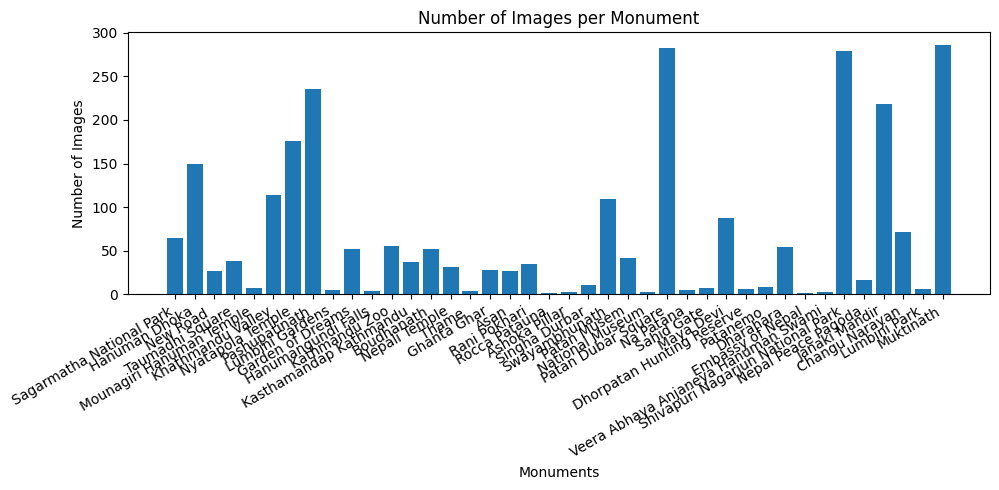

In [ ]:
plot_monument_distribution(class_info)

#Those classes used for training

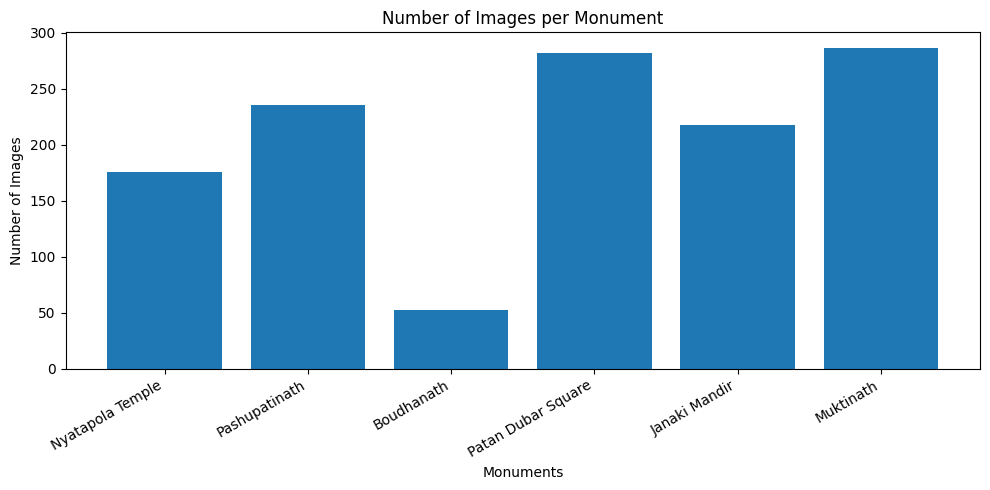

In [ ]:
classes_to_keep = [
    "Muktinath",
    "Patan Dubar Square",
    "Pashupatinath",
    "Janaki Mandir",
    "Nyatapola Temple",
    "Boudhanath"
]
id_to_keep = [c[0] for c in sorted_classes if c[1]['name'] in classes_to_keep]
plot_monument_distribution(class_info, classes_to_keep)

#DATA AUGMENTATION SETUP

In [ ]:

print("\nAugmentation parameters:")
print("- Rotation: ±25 degrees")
print("- Width/Height Shift: ±20%")
print("- Shear Range: 0.2")
print("- Zoom Range: ±20%")
print("- Horizontal Flip: Yes")
print("- Brightness: 70%-130%")

augmentation_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)


Augmentation parameters:
- Rotation: ±25 degrees
- Width/Height Shift: ±20%
- Shear Range: 0.2
- Zoom Range: ±20%
- Horizontal Flip: Yes
- Brightness: 70%-130%


In [ ]:
def augment_images(source_images, source_path, dest_path, target_count, monument_name):
    """Generate augmented images to reach target count"""
    current_count = len(source_images)
    images_needed = target_count - current_count

    if images_needed <= 0:
        return 0

    print(f"\n  Augmenting: {monument_name}")
    print(f"  - Current: {current_count} images")
    print(f"  - Target: {target_count} images")
    print(f"  - Generating: {images_needed} new images")

    # Copying original images first
    for img_name in source_images:
        src_img = os.path.join(source_path, img_name)
        dst_img = os.path.join(dest_path, img_name)
        shutil.copy2(src_img, dst_img)

    # To Generate augmented images
    augmented_count = 0
    images_per_original = int(np.ceil(images_needed / current_count))

    for idx, img_name in enumerate(source_images):
        if augmented_count >= images_needed:
            break

        img_path = os.path.join(source_path, img_name)

        try:
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            gen = augmentation_generator.flow(img_array, batch_size=1)

            for i in range(images_per_original):
                if augmented_count >= images_needed:
                    break

                augmented_array = next(gen)[0].astype('uint8')
                augmented_img = array_to_img(augmented_array)

                base_name = os.path.splitext(img_name)[0]
                ext = os.path.splitext(img_name)[1]
                aug_name = f"{base_name}_aug_{augmented_count}{ext}"
                aug_path = os.path.join(dest_path, aug_name)

                augmented_img.save(aug_path)
                augmented_count += 1

                if (augmented_count % 50) == 0:
                    print(f"  - Generated: {augmented_count}/{images_needed}")

        except Exception as e:
            print(f"Error augmenting {img_name}: {e}")

    print(f"Final count: {current_count + augmented_count}")
    return augmented_count

In [ ]:
def create_balanced_dataset(id_to_keep, class_info, target_count):
    """Create balanced dataset with augmentation and undersampling"""
    print(f"\nProcessing {len(classes_to_keep)} monuments...")

    total_images_created = 0
    augmentation_stats = {}

    for monument_id in id_to_keep:
        print(f"\n{'='*60}")
        print(f"Monument: {class_info[monument_id]['name']}")
        print(f"ID: {monument_id}")
        print(f"{'='*60}")

        src_path = class_info[monument_id]['path']
        dst_path = os.path.join(OUTPUT_PATH, monument_id)
        os.makedirs(dst_path, exist_ok=True)

        source_images = class_info[monument_id]['images']
        current_count = len(source_images)
        # target_count = balancing_plan[monument_id]['target']
        monument_name = class_info[monument_id]['name']

        if current_count < TARGET_MIN_IMAGES:
            print(f"Action: AUGMENTING")
            aug_count = augment_images(source_images, src_path, dst_path, target_count, monument_name)
            final_count = current_count + aug_count
            augmentation_stats[monument_id] = {
                'id': monument_id,
                'name': monument_name,
                'original': current_count,
                'augmented': aug_count,
                'final': final_count,
                'action': 'augmented'
            }
        else:
            print(f"Action: KEEPING AS IS")
            print(f"  - Count: {current_count} images (within target range)")
            for img_name in source_images:
                src_img = os.path.join(src_path, img_name)
                dst_img = os.path.join(dst_path, img_name)
                shutil.copy2(src_img, dst_img)
            final_count = current_count
            print(f"Copied {final_count} images")
            augmentation_stats[monument_id] = {
                'id': monument_id,
                'name': monument_name,
                'original': current_count,
                'final': final_count,
                'action': 'kept'
            }

        total_images_created += final_count

    return augmentation_stats, total_images_created

In [ ]:
augmentation_stats, total_final_images = create_balanced_dataset(
        ["168267"], class_info, TARGET_MIN_IMAGES
    )


Processing 6 monuments...

Monument: Boudhanath
ID: 168267
Action: AUGMENTING

  Augmenting: Boudhanath
  - Current: 52 images
  - Target: 200 images
  - Generating: 148 new images
  - Generated: 50/148
  - Generated: 100/148
Final count: 200


#After Agumentation

In [ ]:
class_info, total_images = collect_dataset_info(OUTPUT_PATH, id_to_name)

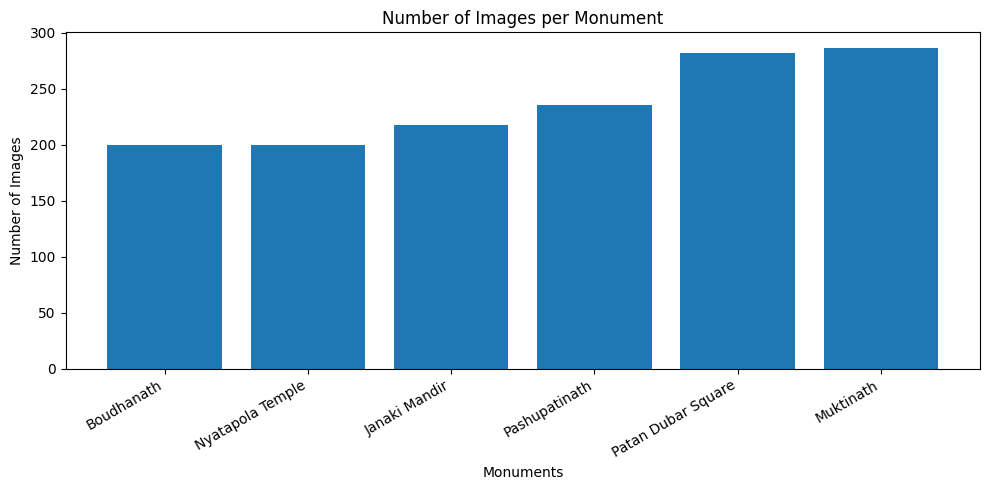

In [ ]:
plot_monument_distribution(class_info, classes_to_keep)

In [ ]:
print("Id,Monument Name,Image Count")
for info in class_info.values():
    print(f"{info["id"]},{info["name"]},{info['count']}")

Id,Monument Name,Image Count
98003,Muktinath,286
4137,Patan Dubar Square,282
152527,Pashupatinath,235
79922,Janaki Mandir,218
122791,Nyatapola Temple,200
168267,Boudhanath,200


#Image Dimensions

In [ ]:
from PIL import Image

In [ ]:
print("\nCollecting image dimension data...")

def collect_image_dimensions(dataset_path, max_samples=300):
    """
    Collect dimension information from images
    """
    widths = []
    heights = []
    aspect_ratios = []
    file_sizes_kb = []
    orientations = []
    resolutions = []
    image_paths = []

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.JPG', '.JPEG', '.PNG'}

    sample_count = 0
    total_folders = 0

    # Get all monument folders
    folders = [f for f in os.listdir(dataset_path)
               if os.path.isdir(os.path.join(dataset_path, f))]
    total_folders = len(folders)

    print(f"Found {total_folders} monument folders")
    print(f"Target: Analyze {max_samples} images\n")

    for monument_id in folders:
        if sample_count >= max_samples:
            break

        monument_path = os.path.join(dataset_path, monument_id)
        images = [f for f in os.listdir(monument_path)
                 if os.path.splitext(f)[1] in valid_extensions]

        # Sample images from this monument
        sample_count_per_monument = min(5, len(images))
        sampled_images = np.random.choice(images, sample_count_per_monument, replace=False) if len(images) > 0 else []

        for img_name in sampled_images:
            if sample_count >= max_samples:
                break

            img_path = os.path.join(monument_path, img_name)

            try:
                # Open image and get dimensions
                with Image.open(img_path) as img:
                    w, h = img.size

                    widths.append(w)
                    heights.append(h)
                    aspect_ratios.append(w / h)

                    # File size
                    file_size_bytes = os.path.getsize(img_path)
                    file_sizes_kb.append(file_size_bytes / 1024)

                    # Resolution in megapixels
                    megapixels = (w * h) / 1_000_000
                    resolutions.append(megapixels)

                    # Orientation
                    if w > h * 1.1:
                        orientations.append('Landscape')
                    elif h > w * 1.1:
                        orientations.append('Portrait')
                    else:
                        orientations.append('Square')

                    image_paths.append(img_path)
                    sample_count += 1

                    if sample_count % 50 == 0:
                        print(f"  Processed: {sample_count}/{max_samples} images")

            except Exception as e:
                print(f"Error reading {img_path}: {e}")
                continue

    print(f"\nSuccessfully analyzed {sample_count} images")

    return {
        'widths': widths,
        'heights': heights,
        'aspect_ratios': aspect_ratios,
        'file_sizes_kb': file_sizes_kb,
        'orientations': orientations,
        'resolutions': resolutions,
        'image_paths': image_paths
    }

# Collect data
data = collect_image_dimensions(OUTPUT_PATH, max_samples=300)

widths = np.array(data['widths'])
heights = np.array(data['heights'])
aspect_ratios = np.array(data['aspect_ratios'])
file_sizes_kb = np.array(data['file_sizes_kb'])
orientations = data['orientations']
resolutions = np.array(data['resolutions'])



Found 6 monument folders
Target: Analyze 300 images


Successfully analyzed 30 images


In [ ]:
from collections import Counter

In [ ]:
print("STATISTICAL SUMMARY")

print(f"\nAnalyzed: {len(widths)} images")

print("\n" + "-"*80)
print("WIDTH STATISTICS (pixels)")
print("-"*80)
print(f"  Minimum:          {np.min(widths):>10.0f}")
print(f"  Maximum:          {np.max(widths):>10.0f}")
print(f"  Mean:             {np.mean(widths):>10.0f}")


print("\n" + "-"*80)
print("HEIGHT STATISTICS (pixels)")
print("-"*80)
print(f"  Minimum:          {np.min(heights):>10.0f}")
print(f"  Maximum:          {np.max(heights):>10.0f}")
print(f"  Mean:             {np.mean(heights):>10.0f}")

print("\n" + "-"*80)
print("ASPECT RATIO STATISTICS (Width/Height)")
print("-"*80)
print(f"  Minimum:          {np.min(aspect_ratios):>10.2f}")
print(f"  Maximum:          {np.max(aspect_ratios):>10.2f}")
print(f"  Mean:             {np.mean(aspect_ratios):>10.2f}")
print(f"  Median:           {np.median(aspect_ratios):>10.2f}")
print(f"  Standard Dev:     {np.std(aspect_ratios):>10.2f}")

print("\n" + "-"*80)
print("RESOLUTION STATISTICS (Megapixels)")
print("-"*80)
print(f"  Minimum:          {np.min(resolutions):>10.2f} MP")
print(f"  Maximum:          {np.max(resolutions):>10.2f} MP")
print(f"  Mean:             {np.mean(resolutions):>10.2f} MP")


print("\n" + "-"*80)
print("FILE SIZE STATISTICS (KB)")
print("-"*80)
print(f"  Minimum:          {np.min(file_sizes_kb):>10.1f} KB")
print(f"  Maximum:          {np.max(file_sizes_kb):>10.1f} KB")
print(f"  Mean:             {np.mean(file_sizes_kb):>10.1f} KB")
print(f"  Total (all):      {np.sum(file_sizes_kb)/1024:>10.1f} MB")

print("\n" + "-"*80)
print("ORIENTATION DISTRIBUTION")
print("-"*80)
orientation_counts = Counter(orientations)
for orientation, count in sorted(orientation_counts.items()):
    percentage = (count / len(orientations)) * 100
    print(f"  {orientation:<12}: {count:>4} images ({percentage:>5.1f}%)")

STATISTICAL SUMMARY

Analyzed: 30 images

--------------------------------------------------------------------------------
WIDTH STATISTICS (pixels)
--------------------------------------------------------------------------------
  Minimum:                 640
  Maximum:                6000
  Mean:                   3527

--------------------------------------------------------------------------------
HEIGHT STATISTICS (pixels)
--------------------------------------------------------------------------------
  Minimum:                 480
  Maximum:                7936
  Mean:                   2951

--------------------------------------------------------------------------------
ASPECT RATIO STATISTICS (Width/Height)
--------------------------------------------------------------------------------
  Minimum:                0.36
  Maximum:                1.83
  Mean:                   1.32
  Median:                 1.33
  Standard Dev:           0.34

------------------------------------

#Visualize sample images

In [ ]:
import random

In [ ]:
def visualize_samples(dataset_dir, samples_per_class=3):
    class_names = os.listdir(dataset_dir)
    class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_dir, cls))]

    plt.figure(figsize=(15, 8))
    img_index = 1

    for class_name in class_names:
        class_path = os.path.join(dataset_dir, class_name)
        images = os.listdir(class_path)
        images = random.sample(images, min(samples_per_class, len(images)))

        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(len(class_names), samples_per_class, img_index)
            plt.imshow(img)
            plt.axis("off")

            if img_index <= samples_per_class:
                plt.title(class_name)

            img_index += 1

    plt.tight_layout()
    plt.show()


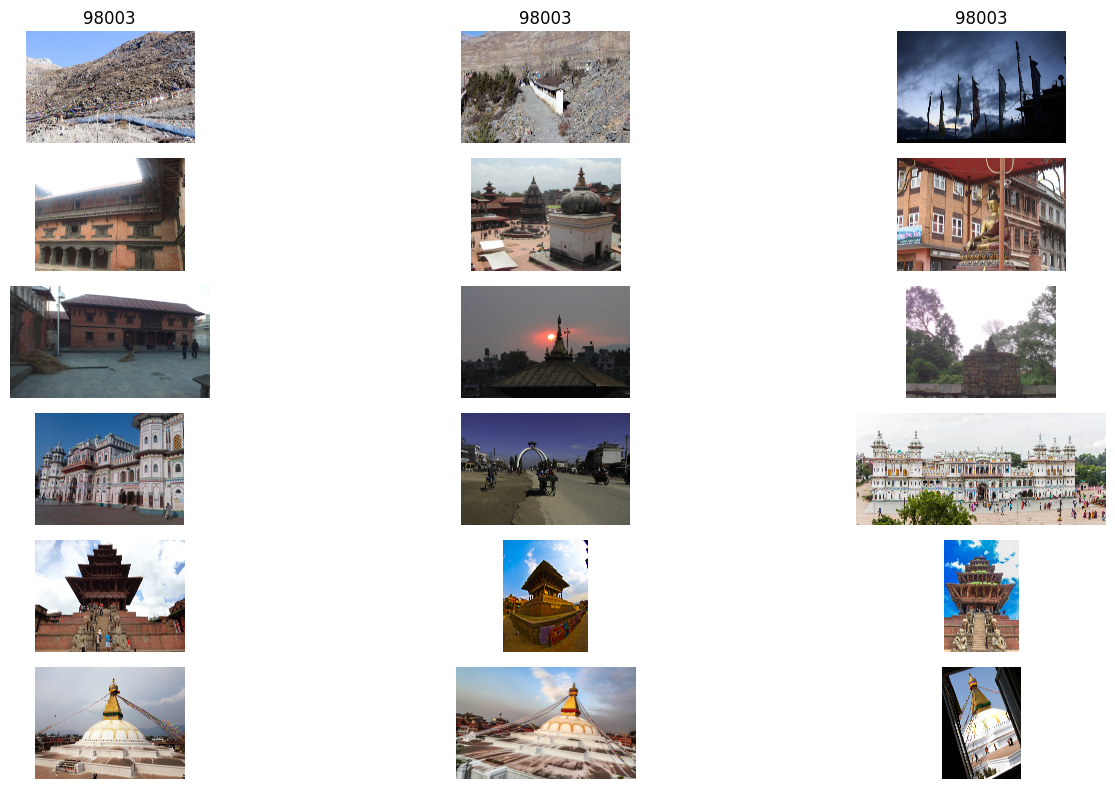

In [ ]:
visualize_samples(OUTPUT_PATH, samples_per_class=3)
